### Import and Load Cleaned Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [2]:
# load in cleaned dataset
df = pd.read_csv('capstone_data_cleaned.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df1 = df.copy()
df.set_index('DATE', inplace=True)
df_total = df.copy()
df_total = df_total[['PASSENGERS']].resample("MS").sum()

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390469 entries, 2013-01-01 to 2024-05-01
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   DEPARTURES_PERFORMED  390469 non-null  float64
 1   SEATS                 390469 non-null  float64
 2   PASSENGERS            390469 non-null  float64
 3   CARRIER               390435 non-null  object 
 4   CARRIER_NAME          390469 non-null  object 
 5   ORIGIN_AIRPORT_ID     390469 non-null  int64  
 6   ORIGIN_CITY_NAME      390469 non-null  object 
 7   ORIGIN_COUNTRY_NAME   390469 non-null  object 
 8   DEST_AIRPORT_ID       390469 non-null  int64  
 9   DEST_CITY_NAME        390469 non-null  object 
 10  DEST_COUNTRY_NAME     390469 non-null  object 
 11  YEAR                  390469 non-null  int64  
 12  MONTH                 390469 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 41.7+ MB
None


DEPARTURES_PERFORMED    SEATS  PASSENGERS CARRIER  \
DATE                                                            
2013-01-01                   1.0    526.0       483.0      LH   
2013-01-01                  31.0  10848.0      7555.0      LH   
2013-01-01                  10.0    370.0       259.0      MQ   
2013-01-01                  10.0    440.0       253.0      MQ   
2013-01-01                  31.0  10726.0      4944.0      MS   

                            CARRIER_NAME  ORIGIN_AIRPORT_ID  \
DATE                                                          
2013-01-01     Lufthansa German Airlines              13303   
2013-01-01     Lufthansa German Airlines              11618   
2013-01-01  American Eagle Airlines Inc.              11298   
2013-01-01  American Eagle Airlines Inc.              12953   
2013-01-01                      Egyptair              12478   

                 ORIGIN_CITY_NAME ORIGIN_COUNTRY_NAME  DEST_AIRPORT_ID  \
DATE                                                                     
2013-01-01              Miami, FL       United States            10970   
2013-01-01             Newark, NJ       United States            11760   
2013-01-01  Dallas/Fort Worth, TX       United States            14879   
2013-01-01           New York, NY       United States            16217   
2013-01-01           New York, NY       United States            10872   

                     DEST_CITY_NAME DEST_COUNTRY_NAME  YEAR  MONTH  
DATE                                                                
2013-01-01         Cologne, Germany           Germany  2013      1  
2013-01-01       Frankfurt, Germany           Germany  2013      1  
2013-01-01  San Luis Potosi, Mexico            Mexico  2013      1  
2013-01-01         Montreal, Canada            Canada  2013      1  
2013-01-01             Cairo, Egypt             Egypt  2013      1

### Stationarity

In [4]:
M_mean = df_total.rolling(window=12).mean()
M_STD = df_total.rolling(window=12).std()

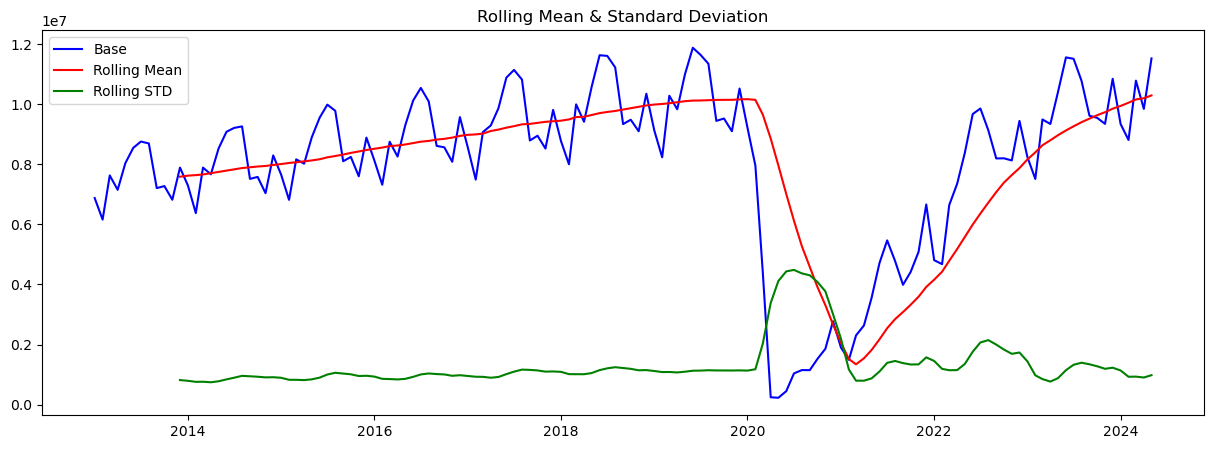

In [5]:
# check for stationarity visually
plt.figure(figsize=(15,5))
plt.plot(df_total, color='blue', label='Base')
plt.plot(M_mean, color='red', label='Rolling Mean')
plt.plot(M_STD, color='green', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [6]:
# function to check stationarity based on Augmented Dickey-Fuller test
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        return True
    else:
        return False

In [7]:
check_stationarity(df_total['PASSENGERS'])

False

From the plot above, it can be inferred that this time series is non-stantionary as the mean and standard deviation are changing over time. Also, trend and seasonality component can be seen. As another test for stationarity, the Augmented Dickey-Fuller Test shows the p-value is greater than 0.05; therefore, it is non-stationary.

### Preprocess Each Destination

In [8]:
# group the dataset by destination and sum of passengers
df_dest = df1.copy()
df_dest = df_dest[['DATE', 'PASSENGERS','DEST_CITY_NAME']].groupby(['DATE','DEST_CITY_NAME'], as_index=False)['PASSENGERS'].sum().sort_values(by=['DATE','PASSENGERS'], ascending=[True,False])
df_dest['DATE'] = pd.to_datetime(df_dest['DATE'])
df_dest

DATE              DEST_CITY_NAME  PASSENGERS
116   2013-01-01      London, United Kingdom    517423.0
226   2013-01-01             Toronto, Canada    422479.0
224   2013-01-01                Tokyo, Japan    373605.0
39    2013-01-01              Cancun, Mexico    247724.0
135   2013-01-01         Mexico City, Mexico    240324.0
...          ...                         ...         ...
35174 2024-05-01               Gerona, Spain         1.0
35188 2024-05-01            Hamburg, Germany         1.0
35196 2024-05-01  Humberside, United Kingdom         1.0
35228 2024-05-01              Macapa, Brazil         1.0
35373 2024-05-01             Zaragoza, Spain         1.0

[35375 rows x 3 columns]

In [9]:
# top '10' destinations each month every year
top_dest = df_dest.groupby(['DATE']).apply(lambda x: x.head(10)).reset_index(drop=True)
top_dest

DATE          DEST_CITY_NAME  PASSENGERS
0    2013-01-01  London, United Kingdom    517423.0
1    2013-01-01         Toronto, Canada    422479.0
2    2013-01-01            Tokyo, Japan    373605.0
3    2013-01-01          Cancun, Mexico    247724.0
4    2013-01-01     Mexico City, Mexico    240324.0
...         ...                     ...         ...
1365 2024-05-01      Frankfurt, Germany    354768.0
1366 2024-05-01     Mexico City, Mexico    347926.0
1367 2024-05-01       Vancouver, Canada    311201.0
1368 2024-05-01  Amsterdam, Netherlands    302083.0
1369 2024-05-01      Seoul, South Korea    284783.0

[1370 rows x 3 columns]

In [10]:
# find the minimum passenger in the monthly top 10 destination
top_dest[top_dest['PASSENGERS'] == top_dest['PASSENGERS'].min()]

DATE  DEST_CITY_NAME  PASSENGERS
889 2020-05-01  Taipei, Taiwan      5407.0

In [11]:
# filter the main dataframe with passengers greater than the minimum threshold
df_min = df_dest[df_dest['PASSENGERS'] > top_dest['PASSENGERS'].min()]

# keep the cities with date points missing less than 24 months (2020-2022)
df_keep = df_min[df_min['DEST_CITY_NAME'].map(df_min['DEST_CITY_NAME'].value_counts()) > 113]

df_keep['DEST_CITY_NAME'].value_counts()

DEST_CITY_NAME
London, United Kingdom    137
Guadalajara, Mexico       137
Tokyo, Japan              137
Mexico City, Mexico       137
Frankfurt, Germany        137
                         ... 
Amman, Jordan             116
Geneva, Switzerland       114
Ottawa, Canada            114
Georgetown, Guyana        114
Winnipeg, Canada          114
Name: count, Length: 93, dtype: int64

To get a more accurate dataset of destinations, the dataset is filtered for destinations that had passengers greater than any of the monthly top 10 destinations. From there, the dataset is filtered even more to destinations that are missing less than two years of data as there could be outliers from the pandemic as seen from the EDA.

In [12]:
def fill_dates(city):
    '''
    Inputs the monthly number of passengers of a destination and checks for continuity of the datapoints from 2013-01-01 to 2024-05-01.
    Fills in any missing dates by interpolation.

    Input
    -----
    Destination
    
    Output
    ------
    Dataframe interpolated with no missing datapoints
    '''

    df_city = df_dest[df_dest['DEST_CITY_NAME']==city].drop(columns='DEST_CITY_NAME').set_index('DATE').asfreq('MS')
    
    if df_city['PASSENGERS'].isna().sum() > 0:
        df_city['PASSENGERS'] = df_city['PASSENGERS'].interpolate(method='time')
        df_city.rename(columns={'PASSENGERS': city}, inplace=True)
    else:
        df_city.rename(columns={'PASSENGERS': city}, inplace=True)


    return df_city

In [13]:
# combine the monthly number of passengers of all the destinations into one dataframe as the main working dataframe
df_main = []
city_list = df_keep['DEST_CITY_NAME'].unique()
for cl in range(len(city_list)):
    df_main.append(fill_dates(city_list[cl]))
df_main = pd.concat(df_main, axis=1)
df_all = pd.concat([df_total, df_main], axis=1) # dataframe of total passengers and destinations
df_all.head()

PASSENGERS  London, United Kingdom  Toronto, Canada  Tokyo, Japan  \
DATE                                                                            
2013-01-01   6873798.0                517423.0         422479.0      373605.0   
2013-02-01   6156381.0                411641.0         387761.0      349596.0   
2013-03-01   7625669.0                567949.0         501870.0      407785.0   
2013-04-01   7147908.0                644073.0         489343.0      319277.0   
2013-05-01   8033867.0                733345.0         525027.0      386794.0   

            Cancun, Mexico  Mexico City, Mexico  Frankfurt, Germany  \
DATE                                                                  
2013-01-01        247724.0             240324.0            201467.0   
2013-02-01        264890.0             187736.0            167323.0   
2013-03-01        341747.0             218482.0            232239.0   
2013-04-01        261987.0             214770.0            252450.0   
2013-05-01        269585.0             218376.0            330027.0   

            Seoul, South Korea  Paris, France  Vancouver, Canada  ...  \
DATE                                                              ...   
2013-01-01            198960.0       184354.0           166967.0  ...   
2013-02-01            171938.0       155640.0           159644.0  ...   
2013-03-01            189145.0       224858.0           184465.0  ...   
2013-04-01            168312.0       241892.0           176490.0  ...   
2013-05-01            211726.0       310115.0           194628.0  ...   

            Lisbon, Portugal  Cartagena, Colombia  Morelia, Mexico  \
DATE                                                                 
2013-01-01            8460.0               7742.0           7610.0   
2013-02-01            6731.0               5785.0           5758.0   
2013-03-01           11165.0               6086.0           7734.0   
2013-04-01           12501.0               5255.0           6126.0   
2013-05-01           17061.0               6027.0           7065.0   

            Amman, Jordan  Cali, Colombia  Addis Ababa, Ethiopia  \
DATE                                                               
2013-01-01         7419.0          7394.0                 6460.0   
2013-02-01         5750.0          5844.0                 4587.0   
2013-03-01         8201.0          6478.0                 5628.0   
2013-04-01         7894.0          6660.0                 5489.0   
2013-05-01        11011.0          6720.0                 7775.0   

            Warsaw, Poland  Georgetown, Guyana  Helsinki, Finland  \
DATE                                                                
2013-01-01          6452.0              6393.0             6131.0   
2013-02-01          4212.0              4779.0             5467.0   
2013-03-01          7951.0              6248.0             7323.0   
2013-04-01         10736.0              5684.0             7771.0   
2013-05-01         17579.0              4253.0             8261.0   

            Queretaro, Mexico  
DATE                           
2013-01-01             5099.0  
2013-02-01             4744.0  
2013-03-01             5798.0  
2013-04-01             5263.0  
2013-05-01             5350.0  

[5 rows x 94 columns]

Any missing dates less than two years are interpolated for all the targeted destinations. The time series dataframe is ready for decomposition.

### Decomposition

In [14]:
# decompose each destination in the main working dataframe
col = df_all.columns
df_all_decomp = {name: pd.DataFrame() for name in col}
for c in range(0,len(col)):
    df_decomp = df_all[[col[c]]]
    decomp = tsa.seasonal_decompose(df_decomp, model='additive')
    df_all_decomp[col[c]] = df_all[[col[c]]]
    df_all_decomp[col[c]].loc[:,['Trend']]  = decomp.trend
    df_all_decomp[col[c]].loc[:,['Seasonal']] = decomp.seasonal
    df_all_decomp[col[c]].loc[:,['Residual']] = decomp.resid

Each destination is decomposed of its time series elements: Trend, Seasonal, and Residual

In [15]:
# plot the decomposition of all the destinations
city_name = list(df_all_decomp.keys())
comps = ["Trend", "Seasonal", "Residual"]

for n in range(len(city_name)):
    fig = make_subplots(rows=3, cols=1, subplot_titles=comps)
    for i, col in enumerate(comps):
        fig.add_trace(
            go.Scatter(x=df_all_decomp[city_name[n]].index, y=df_all_decomp[city_name[n]][col]),
            row=i+1,
            col=1
        )
    fig.update_layout(height=400, width=600, showlegend=False, title=city_name[n])
    fig.show()

Stationarity of each destination is checked. Time series data needs to be stationary.

In [142]:
# check stationarity of the dataset
non_stationary = []
stationary = []
for all in range(len(df_all.columns)): # total target destinations
    cs = check_stationarity(df_all[df_all.columns[all]])
    if cs==False:
        non_stationary.append(df_all.columns[all])
    else:
        stationary.append(df_all.columns[all])
print(len(non_stationary))
non_stationary

78


['PASSENGERS',
 'London, United Kingdom',
 'Toronto, Canada',
 'Tokyo, Japan',
 'Cancun, Mexico',
 'Mexico City, Mexico',
 'Frankfurt, Germany',
 'Seoul, South Korea',
 'Vancouver, Canada',
 'Sao Paulo, Brazil',
 'Montreal, Canada',
 'Amsterdam, Netherlands',
 'Calgary, Canada',
 'Guadalajara, Mexico',
 'San Jose, Costa Rica',
 'Dubai, United Arab Emirates',
 'Bogota, Colombia',
 'Sydney, Australia',
 'Santo Domingo, Dominican Republic',
 'Taipei, Taiwan',
 'San Jose del Cabo, Mexico',
 'Punta Cana, Dominican Republic',
 'Zurich, Switzerland',
 'San Salvador, El Salvador',
 'Puerto Vallarta, Mexico',
 'Ezeiza, Argentina',
 'Lima, Peru',
 'Rio de Janeiro, Brazil',
 'Edmonton, Canada',
 'Aruba, Aruba',
 'Guatemala City, Guatemala',
 'Dublin, Ireland',
 'Port of Spain, Trinidad and Tobago',
 'Manchester, United Kingdom',
 'Port-au-Prince, Haiti',
 'Istanbul, Turkey',
 'Santiago, Chile',
 'Ottawa, Canada',
 'Brussels, Belgium',
 'Manila, Philippines',
 'Monterrey, Mexico',
 'Rome, Italy',


Initially, out of 94 target destinations, 78 are non-stationary.

In [143]:
# 1st order differencing
df_diff1 = pd.DataFrame()
dest1 = df_all.columns
for d in range(len(dest1)):
    df_diff1[dest1[d]+'_DIFF'] = df_all[dest1[d]].diff(9)
df_diff1.dropna(inplace=True)

In [144]:
# 1st order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff1.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff1[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

32


['PASSENGERS_DIFF',
 'London, United Kingdom_DIFF',
 'Toronto, Canada_DIFF',
 'Tokyo, Japan_DIFF',
 'Frankfurt, Germany_DIFF',
 'Seoul, South Korea_DIFF',
 'Amsterdam, Netherlands_DIFF',
 'Calgary, Canada_DIFF',
 'Panama City, Panama_DIFF',
 'Dubai, United Arab Emirates_DIFF',
 'Taipei, Taiwan_DIFF',
 'Rio de Janeiro, Brazil_DIFF',
 'Tel Aviv, Israel_DIFF',
 'Madrid, Spain_DIFF',
 'Dublin, Ireland_DIFF',
 'Port-au-Prince, Haiti_DIFF',
 'Ottawa, Canada_DIFF',
 'Manila, Philippines_DIFF',
 'Rome, Italy_DIFF',
 'Grand Cayman, Cayman Islands_DIFF',
 'Managua, Nicaragua_DIFF',
 'Doha_DIFF',
 'Winnipeg, Canada_DIFF',
 'Quito, Ecuador_DIFF',
 'Abu Dhabi, United Arab Emirates_DIFF',
 'Willemstad, Curacao_DIFF',
 'Barbados/Bridgetown, Barbados_DIFF',
 'Keflavik/Reykjavik, Iceland_DIFF',
 'Mumbai, India_DIFF',
 'Barcelona, Spain_DIFF',
 'Stockholm, Sweden_DIFF',
 'Queretaro, Mexico_DIFF']

After 1st order of differencing, 32 destinations are non-stationary.

In [145]:
# 2nd order differencing
df_diff2 = pd.DataFrame()
dest2 = df_diff1.columns
for d in range(len(dest2)):
    df_diff2[dest2[d]] = df_diff1[dest2[d]].diff(6)
df_diff2.dropna(inplace=True)

In [146]:
# 2nd order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff2.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff2[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

6


['Frankfurt, Germany_DIFF',
 'Seoul, South Korea_DIFF',
 'Sao Paulo, Brazil_DIFF',
 'Dubai, United Arab Emirates_DIFF',
 'Keflavik/Reykjavik, Iceland_DIFF',
 'Papeete, French Polynesia_DIFF']

After 2nd order of differencing, 6 destinations remain as non-stationary.

In [148]:
# 3rd order differencing
df_diff3 = pd.DataFrame()
dest3 = df_diff2.columns
for d in range(len(dest3)):
    df_diff3[dest3[d]] = df_diff2[dest3[d]].diff(3)
df_diff3.dropna(inplace=True)

In [149]:
# 3rd order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff3.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff3[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

0


[]

Finally, after 3rd order of differencing, all destinations are stationary.

### ACF and PACF Plots

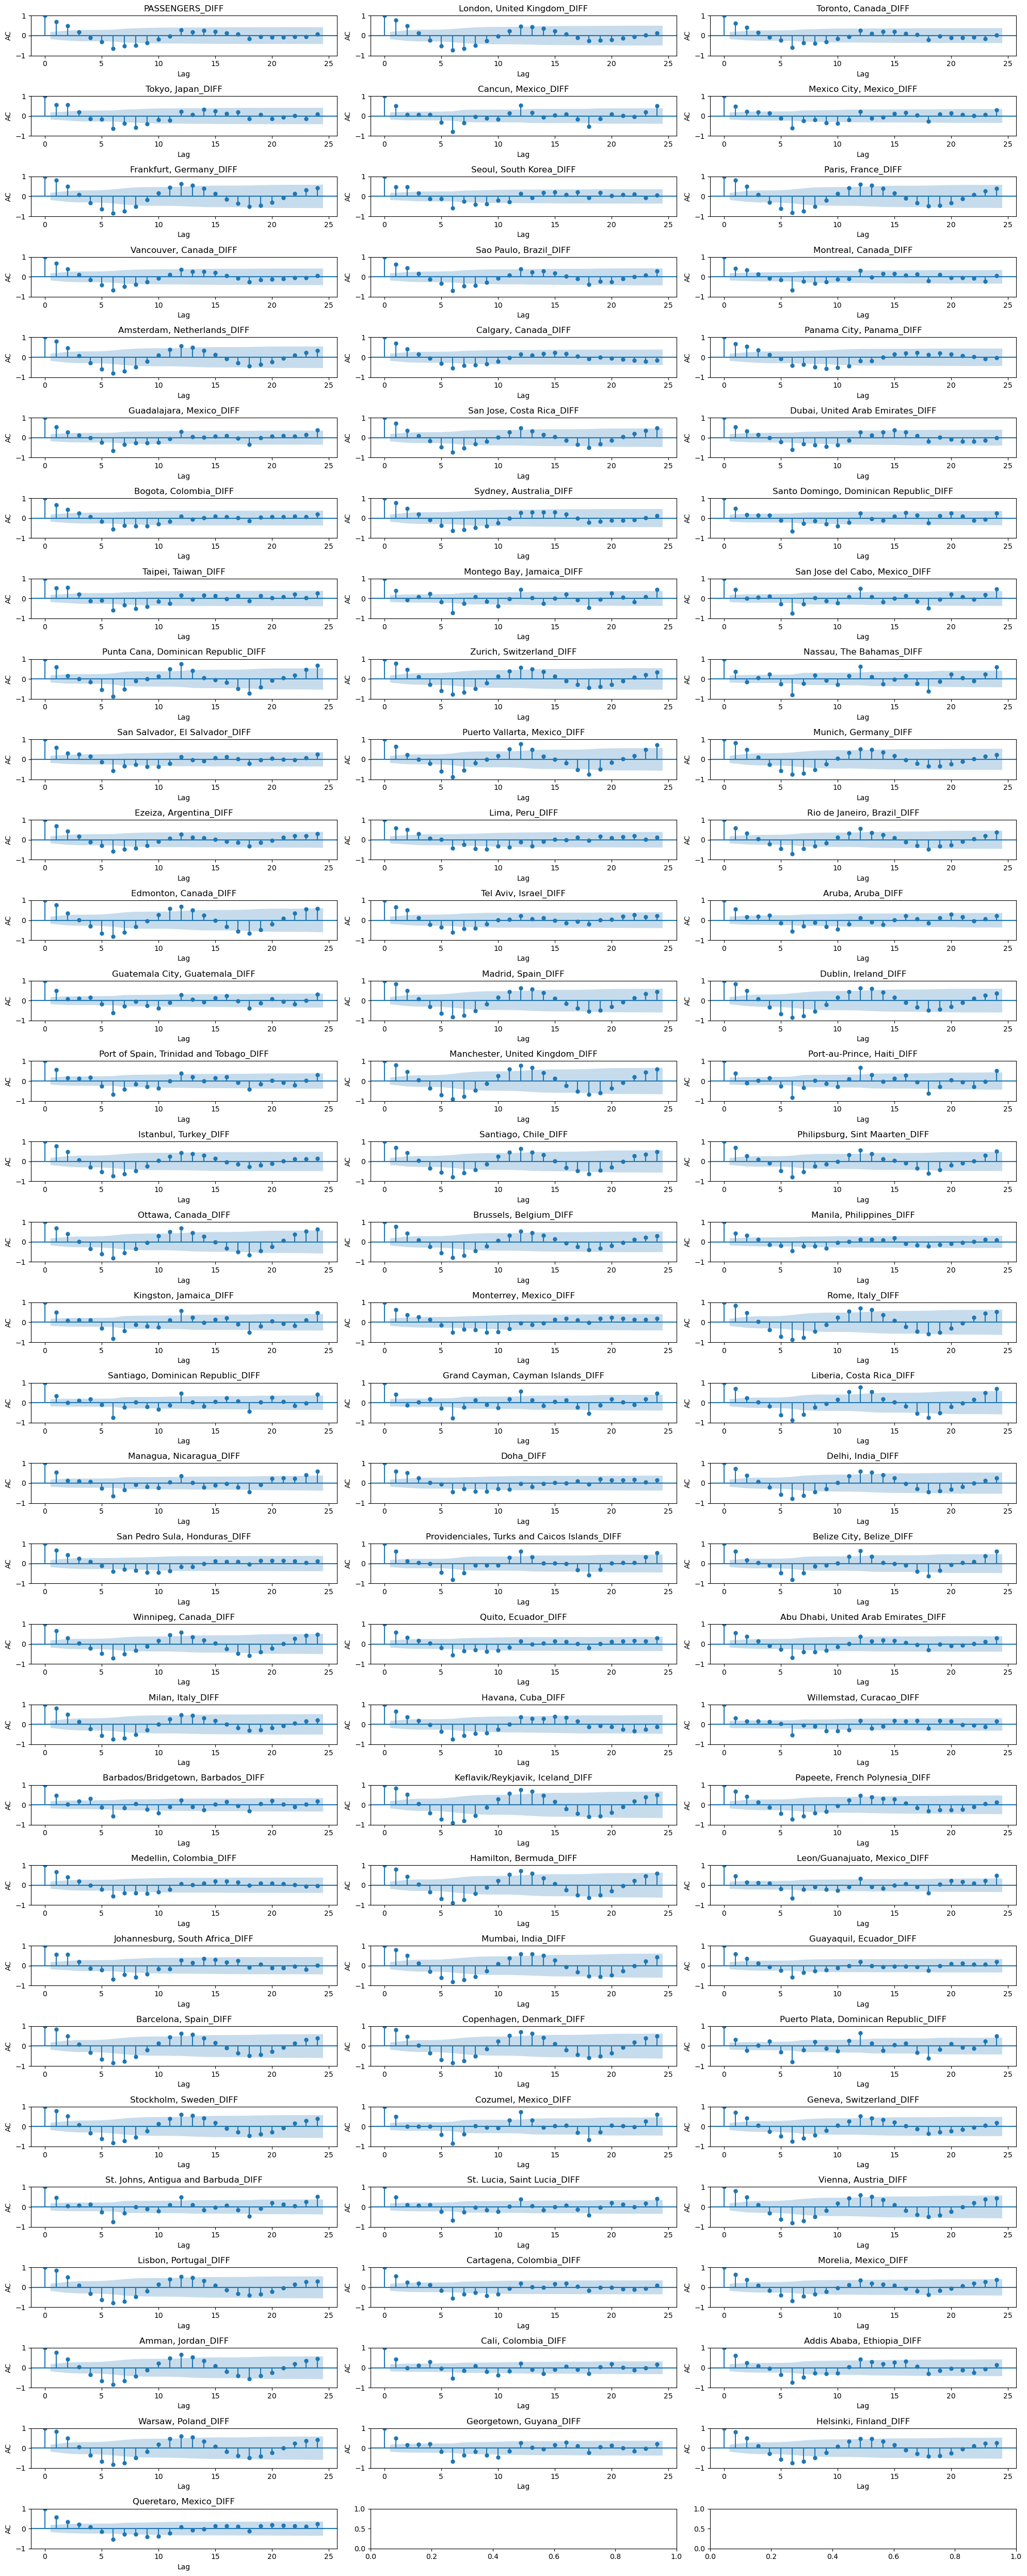

In [155]:
diff = df_diff3.columns
i = 1
plt.subplots(int(len(diff)/3)+1, 3, figsize=(20,50))

for d in diff:
    ax = plt.subplot(int(len(diff)/3)+1,3,i)
    plot_acf(df_diff3[d], lags=24, ax=ax)
    plt.title(d)
    plt.xlabel('Lag')
    plt.ylabel('AC')
    i+=1
    
plt.tight_layout()
plt.show()

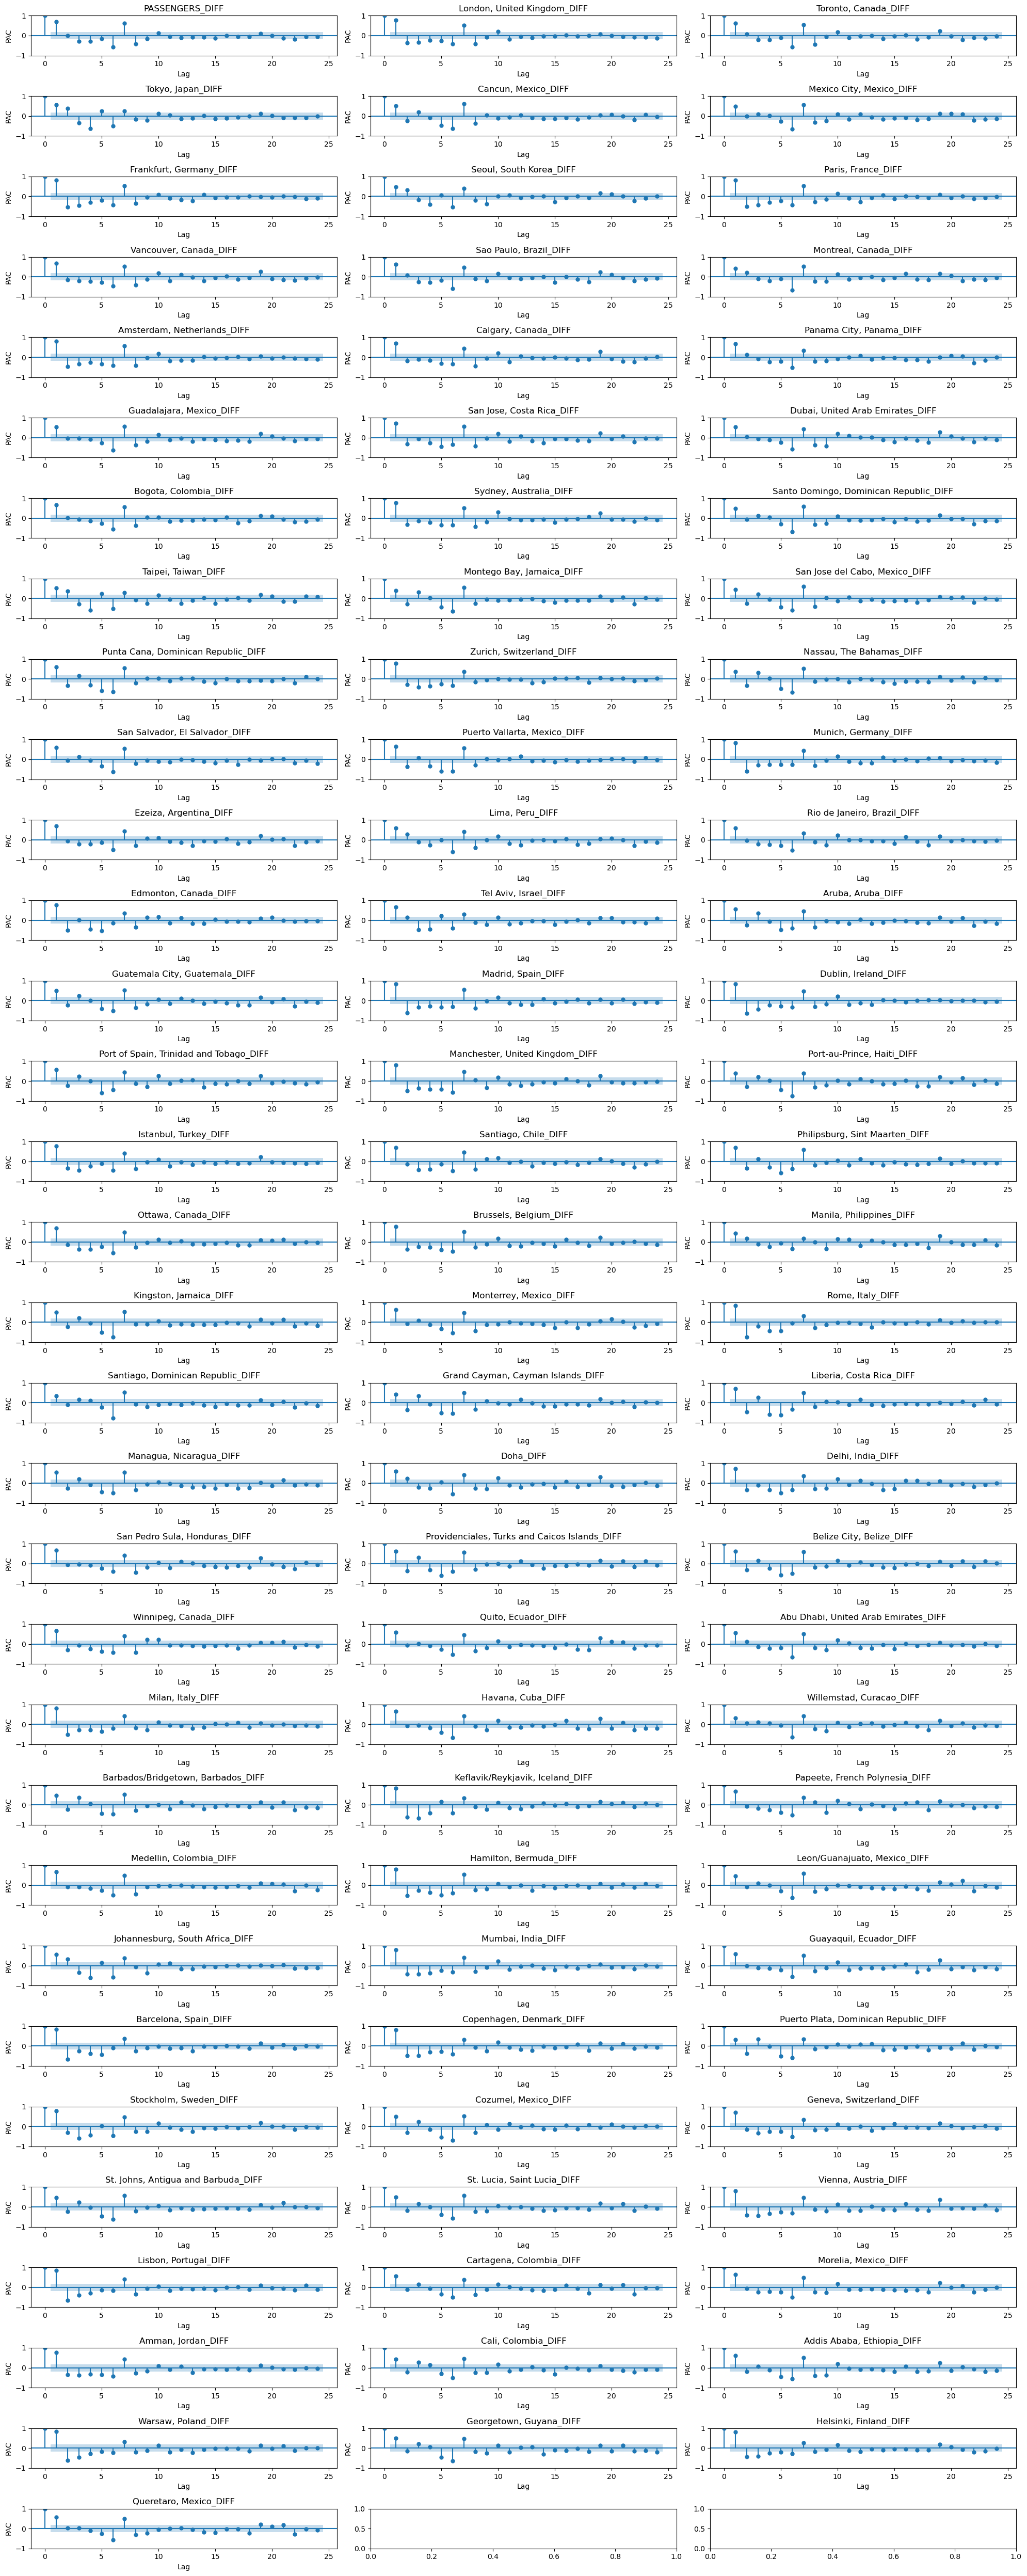

In [156]:
diff = df_diff3.columns
i = 1
plt.subplots(int(len(diff)/3)+1, 3, figsize=(20,50))

for d in diff:
    ax = plt.subplot(int(len(diff)/3)+1,3,i)
    plot_pacf(df_diff3[d], lags=24, ax=ax, method='ywm')
    plt.title(d)
    plt.xlabel('Lag')
    plt.ylabel('PAC')
    i+=1
    
plt.tight_layout()
plt.show()

### Export Files

In [25]:
# # export df_all
# df_all.to_csv('capstone_df_all.csv')

In [26]:
# # export df_main
# df_main.to_csv('capstone_df_main.csv')

In [157]:
# # export df_main_diff
# df_all_diff = df_diff3.copy()
# df_all_diff.to_csv('capstone_df_main_diff.csv')